<a href="https://colab.research.google.com/github/Francesco-Tagliabue/DL-challenges/blob/main/c2/src/FL%2Bcnn%2Branger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Artificial Neural Networks and Deep Learning**

---

## Challenge 2

## 🧮 **Parameters**

In [ ]:
# Set seed for reproducibility
SEED = 42

# Run locally
LOCAL_RUN = 0

# Validation set relative size
N_VAL = 0.2

# Use grayscale instead of RGB
USE_GRAYSCALE = False

# Crop patches
PATCH_SIZE = 156            # Cropped patch size (px)
PATCHES_PER_IMG = 10        # Number of patches per original image
MAX_MASK_DIST = 25          # Maximum patch center distance from mask
MIN_PATCHES_DIST = 60       # Minimum centers distance between patches
KEEP_MASK = False           # Keep mask in the cropped patches

# Augmentation
N_GEOMETRIC = 2      # 2 geo (rot/sposta/shear)
N_COLOR = 2          # 2 color (solo bright/contr)
MAG_GEOMETRIC = 10   # Geo moderato
MAG_COLOR = 8        # Color molto soft (stain safe)

# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 64

# Training configuration
LEARNING_RATE = 1e-4
EPOCHS = 300
PATIENCE = 30

# Architecture
CNN_TYPE = None
PRETRAINED = True
NORM_TYPE = "layer"
CRITERION = "wFocal"
LABEL_SMOOTHING = 0.1

# Regularization
DROPOUT_RATE = 0.4          # Dropout probability
L1_LAMBDA = 0               # L1 penalty
L2_LAMBDA = 5e-5               # L2 penalty

# Scheduler
PATIENCE_SCHED = 10

## ⚙️ **Libraries Import**

In [ ]:
!pip install -q torchview

In [ ]:
# Import necessary libraries
import os
from IPython import get_ipython

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)

# Suppress warnings
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.simplefilter(action = "ignore", category = Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
try:
    import torchummary
except ImportError:
    !pip install torchsummary
from torchsummary import summary
try:
    import tensorboard
except ImportError:
    !pip install tensorboard
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision.transforms import v2 as transforms
import torchvision.models as models
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
try:
    import torchview
except ImportError:
    !pip install torchview
from torchview import draw_graph
import torch.nn.functional as F
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

!mkdir -p "runtime/original/train/gray"
!mkdir -p "runtime/original/train/rgb"
!mkdir -p "runtime/original/test/gray"
!mkdir -p "runtime/original/test/rgb"
!mkdir -p "runtime/crop/train"
!mkdir -p "runtime/crop/test"

# Non-CUDA GPU acceleration support
try:
    import torch_directml
    dml_available = True
except ImportError:
    dml_available = False

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
elif dml_available:
    device = torch_directml.device()
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
try:
    import cv2
except ImportError:
    !pip install opencv-python
    import cv2
import copy
import shutil
from itertools import product
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from PIL import Image
import matplotlib.gridspec as gridspec
import requests
from io import BytesIO
import re
import math
from pathlib import Path
from datetime import datetime

# Configure plot display settings
sns.set(font_scale = 1.4)
sns.set_style("white")
plt.rc("font", size = 14)
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [ ]:
def load_images_from_folder(folder, output, use_grayscale = False):
    """
    Load and preprocess images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        pd.Dataframe: Dataframe of preprocessed images paths with shape (N, H, W, C)
    """
    rows = []

    files = os.listdir(folder)

    # find IDs associated to both image and mask
    pattern_img  = re.compile(r"img_(\d{4})\.png$")
    pattern_mask = re.compile(r"mask_(\d{4})\.png$")

    img_numbers  = set()
    mask_numbers = set()

    for f in files:
        if m := pattern_img.fullmatch(f):
            img_numbers.add(m.group(1))
        if m := pattern_mask.fullmatch(f):
            mask_numbers.add(m.group(1))

    common = img_numbers & mask_numbers

    # Iterate through files in the specified folder
    for n in common:
        img_file  = f"img_{n}.png"
        mask_file = f"mask_{n}.png"

        mask = cv2.imread(os.path.join(folder, mask_file), cv2.IMREAD_GRAYSCALE)

        if use_grayscale:
            img = cv2.imread(os.path.join(folder, img_file), cv2.IMREAD_GRAYSCALE)
            # Merge image and mask
            merge_img = cv2.merge((img, mask))
        else:
            img = cv2.imread(os.path.join(folder, img_file))
            # Merge image (RGB) and mask
            (b_channel, g_channel, r_channel) = cv2.split(img)
            merge_img = cv2.merge((r_channel, g_channel, b_channel, mask))

        # Convert to single-byte
        merge_img = merge_img.astype(np.uint8)

        out_path = os.path.join(output, f"{img_file}.npy")
        np.save(out_path, merge_img)

        if merge_img is not None:
            rows.append({
                "sample_index": img_file,
                "image_path": out_path
            })

    return pd.DataFrame(rows).sort_values('sample_index').reset_index(drop = True)

In [ ]:
def load_from_saved(folder):
    """
    Load already preprocessed images from a specified folder.

    Args:
        folder (str): Path to the folder containing images

    Returns:
        pd.Dataframe: Dataframe of preprocessed images paths with shape (N, H, W, C)
    """
    rows = []

    for f in sorted(os.listdir(folder)):
        if f.endswith(".npy"):
            sample_index = f.replace(".npy", "")  # reverse name logic
            out_path = os.path.join(folder, f)

            rows.append({
                "sample_index": sample_index,
                "image_path": out_path
            })

    return pd.DataFrame(rows).sort_values('sample_index').reset_index(drop = True)

In [ ]:
def load_image(path, normalize = True):
    image = np.load(path)

    if normalize:
        # Normalize to [0, 1] range
        image = image.astype(np.float32) / 255.0

    return image

In [ ]:
def load_indexes(txt_path):
    indexes = set()
    with open(txt_path, "r") as f:
        for line in f:
            name = line.strip()
            if name:
                indexes.add(name)
    return indexes

In [ ]:
# ============================================================
#  Environment detection
# ============================================================

def in_kaggle():
    # Kaggle kernels set this env var
    return "KAGGLE_KERNEL_RUN_TYPE" in os.environ

def in_colab():
    try:
        import google.colab  # type: ignore
        return True
    except ImportError:
        return False

IS_KAGGLE = in_kaggle()
IS_COLAB = in_colab()

assert IS_KAGGLE or IS_COLAB, "This notebook is meant to run on Kaggle or Colab."


# Timestamp used for this run (for folders and model filenames)
RUN_TIMESTAMP = datetime.now().strftime("%Y%m%d_%H%M%S")

if USE_GRAYSCALE:
    orig_train_dir = "runtime/original/train/gray"
    orig_test_dir  = "runtime/original/test/gray"
else:
    orig_train_dir = "runtime/original/train/rgb"
    orig_test_dir  = "runtime/original/test/rgb"


if IS_KAGGLE:
    """
    Directories structure (Kaggle):
    /kaggle/input/an2dlc2
    > train_data/
    > test_data/
    > train_labels.csv

    /kaggle/working
    > data_processed/
    > outputs_<timestamp>/
    """
    RAW_DATA_DIR = Path("/kaggle/input/an2dlc2/")

else:


    if not os.path.exists("data"):
        os.environ['KAGGLE_USERNAME'] = "giorgiamanioudaki"
        os.environ['KAGGLE_KEY'] = "1d894bf85af1afc62f1c89427d9cbf79"

        !kaggle competitions download -c an2dl2526c2v2
        !unzip -o -q an2dl2526c2v2.zip -d data

    RAW_DATA_DIR = Path("data")

if len(os.listdir(orig_train_dir)) > 0:
    print("Found cached preprocessed train images → loading .npy paths...")
    X_train = load_from_saved(orig_train_dir)
else:
    print("No cached train images → processing PNGs...")
    X_train = load_images_from_folder(RAW_DATA_DIR / "train_data", orig_train_dir, use_grayscale = USE_GRAYSCALE)

# Import test data
if len(os.listdir(orig_test_dir)) > 0:
    print("Found cached preprocessed test images → loading .npy paths...")
    X_test = load_from_saved(orig_test_dir)
else:
    print("No cached test images → processing PNGs...")
    X_test = load_images_from_folder(RAW_DATA_DIR / "test_data", orig_test_dir, use_grayscale = USE_GRAYSCALE)

# Import training labels
y_train = pd.read_csv(RAW_DATA_DIR / "train_labels.csv")

import gdown

gdown.download(id = "1bQznQPprgmidZH-wLGHZzrXdtqTNe7Z3", output = "shrek.txt",          quiet = False)
gdown.download(id = "1uqq6po7PJISM2Hd9JAI5rQDZ1iv7HVhj", output = "booger.txt",         quiet = False)

# Import bad indexes
shrek_indexes          = load_indexes("shrek.txt")
booger_indexes         = load_indexes("booger.txt")


assert X_train['sample_index'].equals(y_train['sample_index'])
print("")
print(f"Loaded {len(X_train)} training images")
print(f"Loaded {len(X_test)} test images")



Found cached preprocessed train images → loading .npy paths...
Found cached preprocessed test images → loading .npy paths...


Downloading...
From: https://drive.google.com/uc?id=1bQznQPprgmidZH-wLGHZzrXdtqTNe7Z3
To: /content/shrek.txt
100%|██████████| 779/779 [00:00<00:00, 1.03MB/s]
Downloading...
From: https://drive.google.com/uc?id=1uqq6po7PJISM2Hd9JAI5rQDZ1iv7HVhj
To: /content/booger.txt
100%|██████████| 649/649 [00:00<00:00, 2.39MB/s]


Loaded 691 training images
Loaded 477 test images


## 🔎 **Exploration and Data Analysis**

In [ ]:
def plot_images(X, num_img = 20, images_per_row = 5, index_column = 'sample_index'):
    """
    Plots all images in X with sample index above each image.

    Parameters:
        X: DataFrame with image and index columns
        images_per_row: images per row
    """
    titles = X[index_column].tolist()
    paths = X['image_path'].tolist()

    n = min(num_img, len(paths))
    paths, titles = paths[0:n], titles[0:n]
    rows = math.ceil(n / images_per_row)

    fig, axes = plt.subplots(rows, images_per_row,
                             figsize = (images_per_row * 3, rows * 3),
                             facecolor = "black")

    axes = np.array(axes).reshape(-1)

    for i, (path, title) in enumerate(zip(paths, titles)):
        image = load_image(path)

        # Convert grayscale or 2-channel to 3-channel RGB
        if image.ndim == 2:
            # grayscale → stack 3 channels
            image = np.stack([image, image, image], axis = -1)
        elif image.ndim == 3 and image.shape[-1] == 2:
            # grayscale + mask → add a third zero channel
            zero_channel = np.zeros_like(image[..., 0])
            image = np.dstack([image, zero_channel])

        ax = axes[i]
        ax.imshow(np.clip(image, 0, 1))
        ax.set_title(title, fontsize = 10, color = "white")
        ax.axis("off")

    # Hide empty cells
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.subplots_adjust(left = 0, right = 1, top = 1, bottom = 0,
                        wspace = 0.15, hspace = 0.15)

    plt.show()

In [ ]:

# plot_images(X_train[X_train['sample_index'].isin(shrek_indexes)])

In [ ]:
#plot_images(X_train[X_train['sample_index'].isin(booger_indexes)])

In [ ]:
#plot_images(X_train[X_train['sample_index'].isin(wrong_mask_indexes)])

In [ ]:
# Remove bad training images
bad_indexes = shrek_indexes | booger_indexes

X_train = X_train[~X_train['sample_index'].isin(bad_indexes)].reset_index(drop = True)
y_train = y_train[~y_train['sample_index'].isin(bad_indexes)].reset_index(drop = True)

print(f"Kept {len(X_train)} training images")

Kept 581 training images


In [ ]:
#plot_images(X_train)

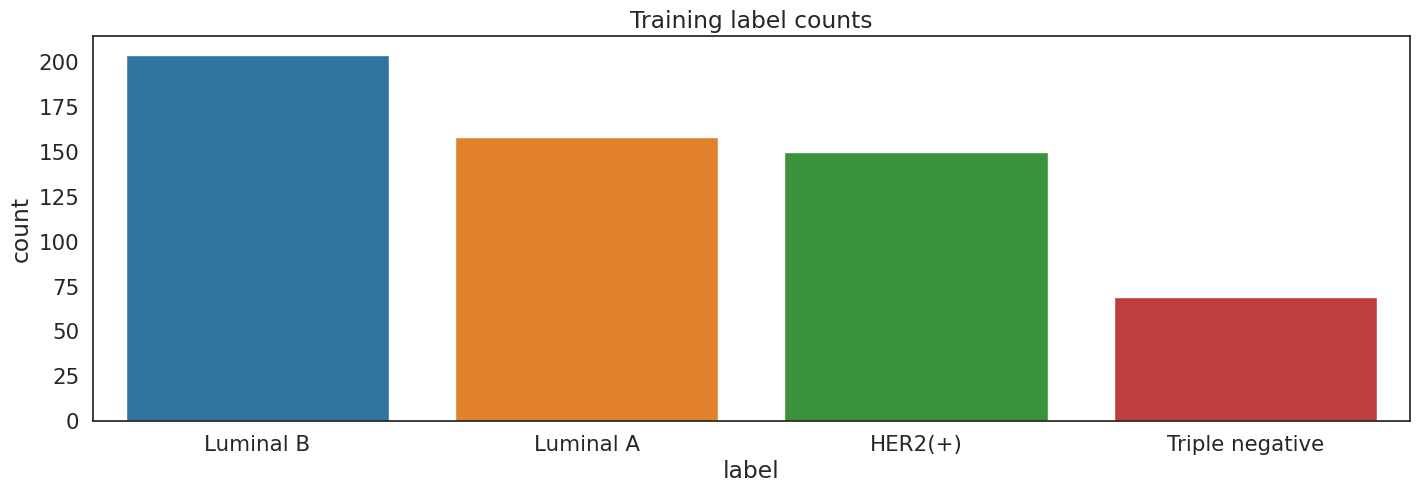

In [ ]:
# Visualise the count of samples for each label
plt.figure(figsize = (17, 5))
sns.countplot(
    x = 'label',
    data = y_train,
    order = y_train['label'].value_counts().index,
    palette = "tab10"
)

# Set the title of the plot
plt.title("Training label counts")

# Display the plot
plt.show()

In [ ]:
#plot_images(X_train[y_train['label'] == "Luminal A"])

In [ ]:
#plot_images(X_train[y_train['label'] == "Luminal B"])

In [ ]:
#plot_images(X_train[y_train['label'] == "HER2(+)"])

In [ ]:
#plot_images(X_train[y_train['label'] == "Triple negative"])

## 🔄 **Data Preprocessing**

In [ ]:
# Define a mapping of label names to integers
le = LabelEncoder()
le.fit(y_train['label'])

# Map strings -> integers
y_train['label'] = le.transform(y_train['label'])

# Save mapping dict (string -> int) and reverse
label_to_int = {cls: i for i, cls in enumerate(le.classes_)}
int_to_label = {i: cls for i, cls in enumerate(le.classes_)}

print(label_to_int)

{'HER2(+)': 0, 'Luminal A': 1, 'Luminal B': 2, 'Triple negative': 3}


In [ ]:
class_counts = y_train['label'].value_counts().sort_index()
total = class_counts.sum()

# Compute class weights
class_weights = total / class_counts
class_weights = class_weights / class_weights.sum()  # normalize
class_weights = torch.tensor(class_weights.values, dtype = torch.float32).to(device)

print(f"Class weights: {class_weights}")

Class weights: tensor([0.2058, 0.1954, 0.1513, 0.4474], device='cuda:0')


In [ ]:
# Split samples into training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size = N_VAL,
    stratify = y_train['label'],
    random_state = SEED
)

# Print shapes of the datasets
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Label Shape: {y_train.shape}")
print(f"Validation Data Shape: {X_val.shape}")
print(f"Validation Label Shape: {y_val.shape}")
print(f"Test Data Shape: {X_test.shape}")

Training Data Shape: (464, 2)
Training Label Shape: (464, 2)
Validation Data Shape: (117, 2)
Validation Label Shape: (117, 2)
Test Data Shape: (477, 2)


### Patches building

In [ ]:
def crop_patches(X, output,
                 patch_size = 128,
                 patches_per_img = 10,
                 max_mask_dist = None,
                 min_patches_dist = None,
                 keep_mask = True,
                 random_state = 42):
    """
    From a dataframe X containing images (image + mask), extract small crops
    centered on white mask pixels, generating patches_per_img crops per original image.

    Returns a dataframe with columns:
        - sample_index (same as original)
        - crop_index (unique per image)
        - crop (the cropped image path)
    """
    rng = random.Random(random_state)
    half = patch_size // 2

    if max_mask_dist is None:
        max_mask_dist = patch_size // 2

    if min_patches_dist is None:
        min_patches_dist = patch_size // 4

    results = []

    for _, row in X.iterrows():
        image = load_image(row['image_path'], normalize = False)   # shape: (H, W, C)
        sample_index = row['sample_index']

        H, W, C = image.shape

        # Extract the mask (last channel by default)
        mask = image[:, :, -1]

        # Coordinates within mask
        ys, xs = np.where(mask > 0)
        coords = list(zip(xs, ys))

        # Choose random mask pixels
        sample_coords = rng.sample(coords, min(patches_per_img * 4, len(coords)))

        scored_crops = []

        for (cx, cy) in sample_coords:
            # Random shift within max_mask_dist
            dx = rng.randint(-max_mask_dist, max_mask_dist)
            dy = rng.randint(-max_mask_dist, max_mask_dist)
            cx_shifted = np.clip(cx + dx, half, W - half)
            cy_shifted = np.clip(cy + dy, half, H - half)

            # Crop boundaries
            x1 = cx_shifted - half
            x2 = cx_shifted + half
            y1 = cy_shifted - half
            y2 = cy_shifted + half

            # Ensure crop inside image boundaries
            if x1 < 0 or y1 < 0 or x2 > W or y2 > H:
                continue

            if keep_mask:
                crop = image[y1:y2, x1:x2, :]
            else:
                crop = image[y1:y2, x1:x2, :(C - 1)]   # keep only image channels

            # Convert to single-byte
            crop = crop.astype(np.uint8)

            # Compute mask ratio
            crop_mask = mask[y1:y2, x1:x2]
            mask_ratio = crop_mask.mean() / mask.max()

            scored_crops.append({
                    "crop": crop,
                    "ratio": mask_ratio,
                    "center": (cx_shifted, cy_shifted)
                })

        # Sort by mask ratio descending
        scored_crops.sort(key = lambda x: x['ratio'], reverse = True)

        selected_crops = []

        for item in scored_crops:
            cx, cy = item['center']

            # check distance from already selected patches
            too_close = False
            for s in selected_crops:
                x2, y2 = s['center']
                if (cx - x2)**2 + (cy - y2)**2 < min_patches_dist**2:
                    too_close = True
                    break

            if not too_close:
                selected_crops.append(item)

            if len(selected_crops) == patches_per_img:
                break

        for i, item in enumerate(selected_crops, start = 1):
            crop = item['crop']
            crop_index = f"{sample_index}_crop_{i:02d}"
            out_path = os.path.join(output, f"{crop_index}.npy")
            np.save(out_path, crop)

            results.append({
                "sample_index": sample_index,
                "crop_index": crop_index,
                "image_path": out_path
            })

    return pd.DataFrame(results).sort_values('crop_index').reset_index(drop = True)

In [ ]:
%%time
# Build cropped patches
X_c_train = crop_patches(X_train, "runtime/crop/train",
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         keep_mask = KEEP_MASK,
                         random_state = SEED)
X_c_val   = crop_patches(X_val, "runtime/crop/train",
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         keep_mask = KEEP_MASK,
                         random_state = SEED)
X_c_test  = crop_patches(X_test, "runtime/crop/test",
                         patch_size = PATCH_SIZE,
                         patches_per_img = PATCHES_PER_IMG,
                         max_mask_dist = MAX_MASK_DIST,
                         min_patches_dist = MIN_PATCHES_DIST,
                         keep_mask = KEEP_MASK,
                         random_state = SEED)

y_c_train = X_c_train[['sample_index']].merge(y_train, on = 'sample_index', how = "left")
y_c_val   = X_c_val[['sample_index']]  .merge(y_val,   on = 'sample_index', how = "left")

# Print shapes of the datasets
print(f"Training Data Shape: {X_c_train.shape}")
print(f"Training Label Shape: {y_c_train.shape}")
print(f"Validation Data Shape: {X_c_val.shape}")
print(f"Validation Label Shape: {y_c_val.shape}")
print(f"Test Data Shape: {X_c_test.shape}")

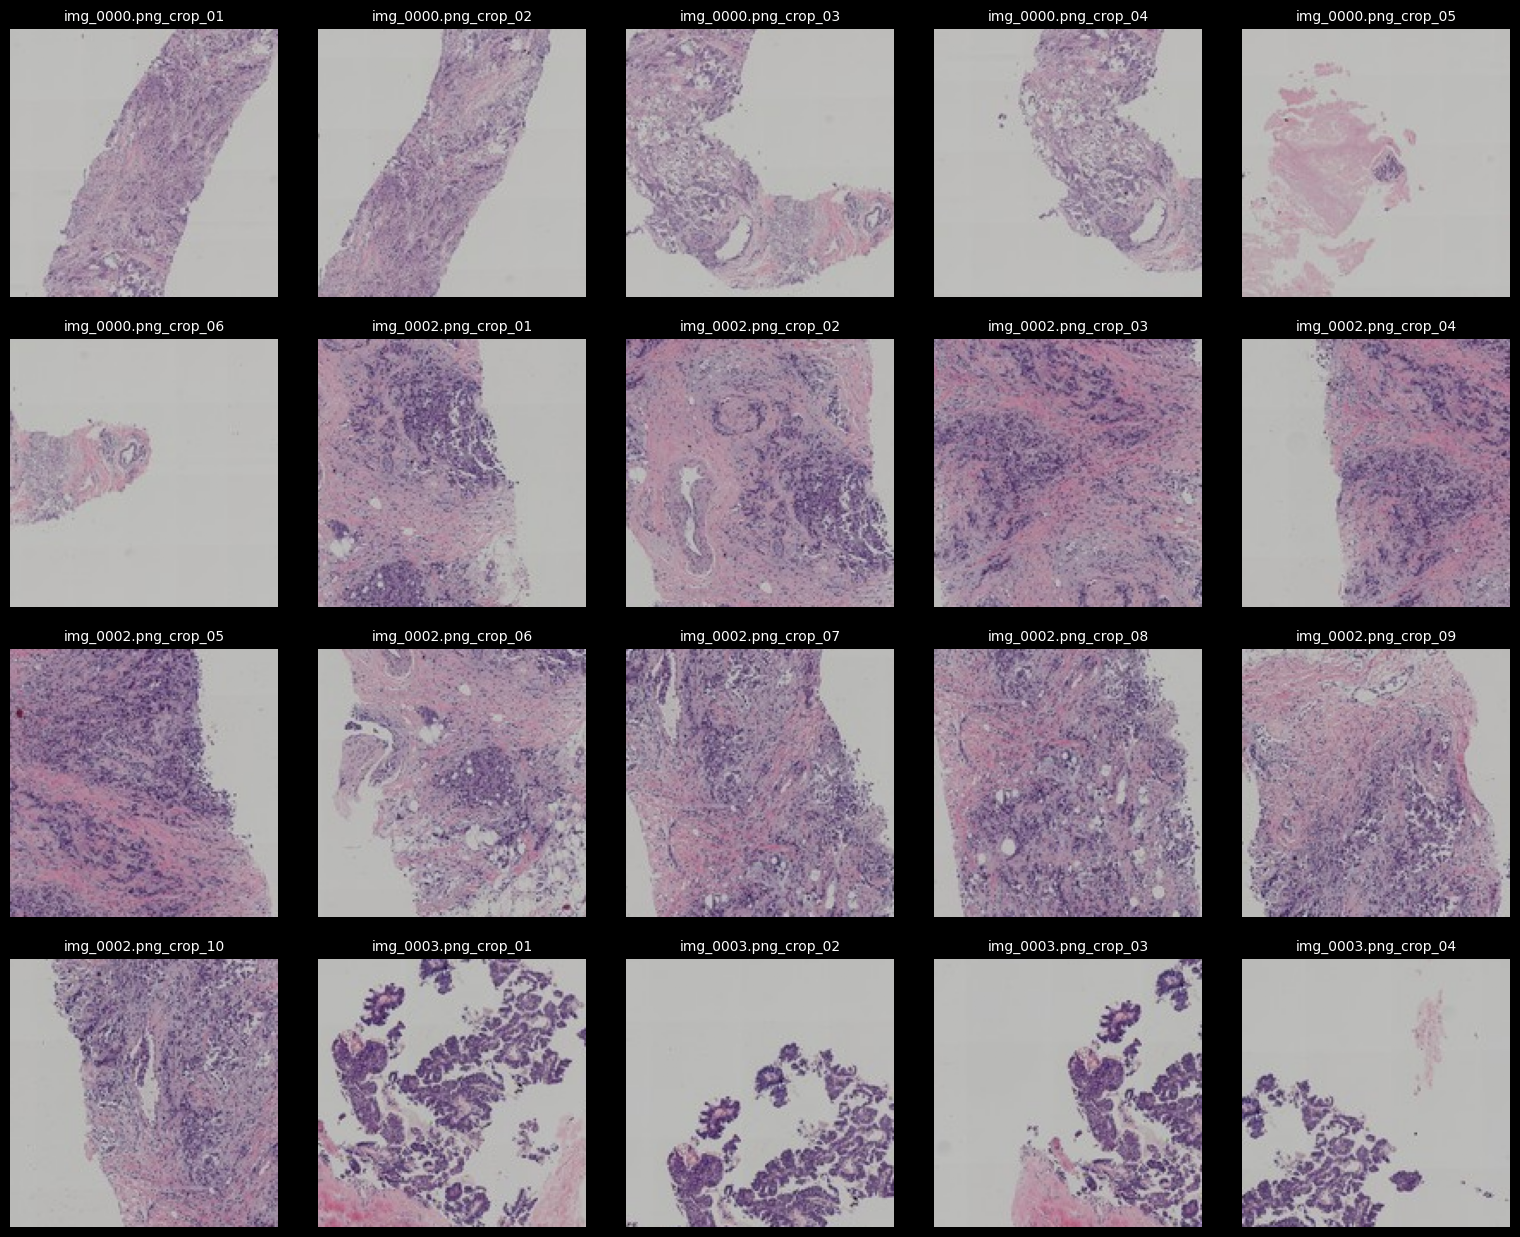

In [ ]:
plot_images(X_c_train, index_column = 'crop_index')

In [ ]:
class_counts = y_c_train['label'].value_counts().sort_index()
total = class_counts.sum()
print("Class counts (patch-level):", class_counts.to_dict())

class_weights = total / class_counts
class_weights = class_weights / class_weights.sum()
class_weights = torch.tensor(class_weights.values, dtype=torch.float32).to(device)
print(f"Class weights (normalized, NOT used in loss): {class_weights}")

# --------- NUOVO: pesi per WeightedRandomSampler ---------
# labels per ogni sample, nello stesso ordine del tuo dataframe y_c_train
labels_np = y_c_train['label'].values.astype(int)
labels_tensor = torch.from_numpy(labels_np)  # shape: (N,)

# Peso per classe = 1 / freq(classe)
counts_tensor = torch.tensor(class_counts.values, dtype=torch.float32)  # shape: (num_classes,)
class_inv_freq = 1.0 / torch.sqrt(counts_tensor)
# Peso per ogni sample = peso della sua classe
sample_weights = class_inv_freq[labels_tensor]  # shape: (N,)

train_sampler = WeightedRandomSampler(
    weights = sample_weights,
    num_samples = len(sample_weights),
    replacement = True,
)

print("Train sampler ready.")


Class counts (patch-level): {0: 1030, 1: 1032, 2: 1373, 3: 447}
Class weights (normalized, NOT used in loss): tensor([0.1979, 0.1975, 0.1485, 0.4561], device='cuda:0')
Train sampler ready.


### PyTorch datasets

In [ ]:
# Define the input shape based on the training data
H, W, C = load_image(X_c_train.loc[0, 'image_path']).shape
input_shape = (C, H, W)

# Define the number of classes
num_classes = len(np.unique(y_c_train['label']))

print("Input Shape:", input_shape)
print("Number of Classes:", num_classes)

Input Shape: (3, 156, 156)
Number of Classes: 4


In [ ]:
from torch.utils.data import Dataset

class PatchTensorDataset(Dataset):
    """
    Dataset basato su array numpy già caricati:
    - images: numpy (N, H, W, C)
    - img_ids: array/list (N,) con sample_index originale (stringa o int)
    - labels: numpy (N,) con etichette (opzionale per test)
    """
    def __init__(self, images, img_ids, labels=None):
        # Salvo le immagini come tensor (N, C, H, W)
        self.images = torch.from_numpy(images).permute(0, 3, 1, 2).float()

        # img_ids può essere np.array di object (es. "img_0001.png"):
        # lo manteniamo come semplice lista Python, NON come tensor.
        self.img_ids = list(img_ids)

        if labels is not None:
            self.labels = torch.from_numpy(labels).long()
        else:
            self.labels = None

    def __len__(self):
        return self.images.size(0)

    def __getitem__(self, idx):
        x = self.images[idx]
        img_id = self.img_ids[idx]   # stringa o int, va bene così

        if self.labels is None:
            # Test set: non abbiamo label
            return img_id, x
        else:
            y = self.labels[idx]
            return img_id, x, y


In [ ]:
train_ids = X_c_train["sample_index"].to_numpy()
val_ids   = X_c_val["sample_index"].to_numpy()
test_ids  = X_c_test["sample_index"].to_numpy()

In [ ]:
X_train_array = np.stack(X_c_train['image_path'].apply(lambda i: load_image(i)).values)
X_val_array   = np.stack(X_c_val['image_path']  .apply(lambda i: load_image(i)).values)
X_test_array  = np.stack(X_c_test['image_path'] .apply(lambda i: load_image(i)).values)

y_train_array = np.array(y_c_train['label'])
y_val_array   = np.array(y_c_val['label'])

# Convert numpy arrays to PyTorch datasets (without augmentation for now)
# train_ds_base = TensorDataset(
#     torch.from_numpy(X_train_array).permute(0, 3, 1, 2),
#     torch.from_numpy(y_train_array).squeeze().long()
# )
# val_ds = TensorDataset(
#     torch.from_numpy(X_val_array).permute(0, 3, 1, 2),
#     torch.from_numpy(y_val_array).squeeze().long()
# )
# test_ds = TensorDataset(
#     torch.from_numpy(X_test_array).permute(0, 3, 1, 2)
# )

# Costruisci i dataset base mantenendo img_id (sample_index)
train_ds_base = PatchTensorDataset(
    images  = X_train_array,
    img_ids = train_ids,
    labels  = y_train_array
)

val_ds_base = PatchTensorDataset(
    images  = X_val_array,
    img_ids = val_ids,
    labels  = y_val_array
)

test_ds_base = PatchTensorDataset(
    images  = X_test_array,
    img_ids = test_ids,
    labels  = None
)


Train patches per classe:
  HER2(+): 1030 patch (26.5%)
  Luminal A: 1032 patch (26.6%)
  Luminal B: 1373 patch (35.4%)
  Triple negative: 447 patch (11.5%)

Val patches per classe:
  HER2(+): 257 patch (26.4%)
  Luminal A: 264 patch (27.1%)
  Luminal B: 336 patch (34.5%)
  Triple negative: 116 patch (11.9%)


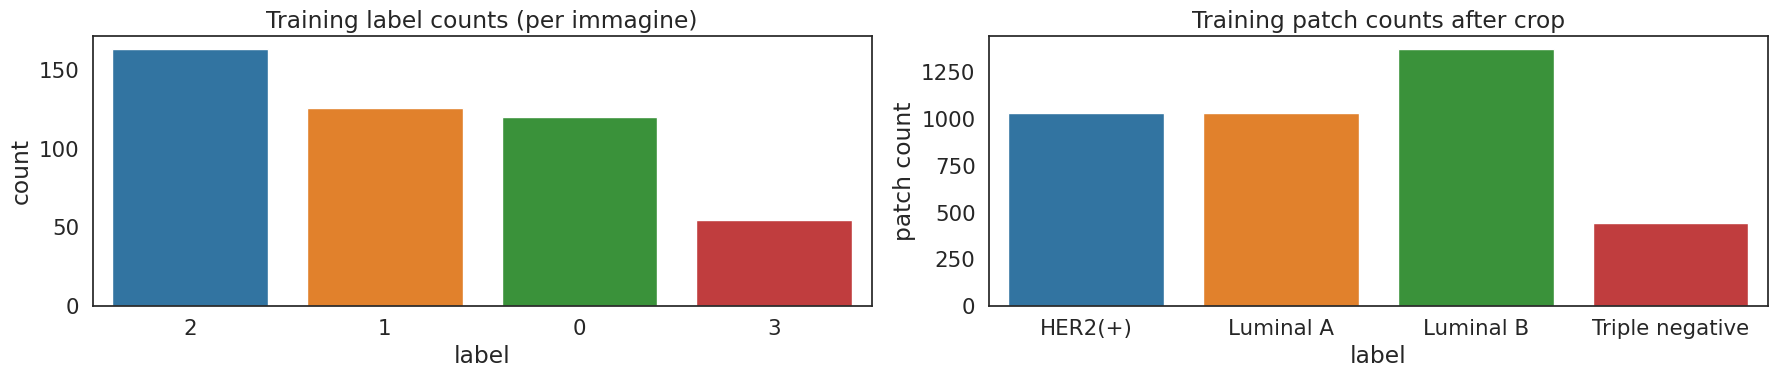

In [ ]:
from collections import Counter
# -------------------------
# 1) Conteggi patch (dopo crop)
# -------------------------
train_counts = Counter(y_train_array.tolist())
val_counts   = Counter(y_val_array.tolist())

classes      = sorted(train_counts.keys())
class_names  = [int_to_label[c] for c in classes]

print("Train patches per classe:")
train_total = len(y_train_array)
for c in classes:
    name = int_to_label[c]
    cnt = train_counts[c]
    print(f"  {name}: {cnt} patch ({cnt/train_total*100:.1f}%)")

print("\nVal patches per classe:")
val_total = len(y_val_array)
for c in classes:
    name = int_to_label[c]
    cnt = val_counts[c]
    print(f"  {name}: {cnt} patch ({cnt/val_total*100:.1f}%)")

# -------------------------
# 2) Grafici BEFORE vs AFTER nella stessa figura
# -------------------------
plt.figure(figsize=(18, 4))

# BEFORE (per immagine, y_train DataFrame)
plt.subplot(1, 2, 1)
sns.countplot(
    x='label',
    data=y_train,          # colonne string (Luminal A, ...)
    order=y_train['label'].value_counts().index,
    palette="tab10"
)
plt.title("Training label counts (per immagine)")
plt.xlabel("label")
plt.ylabel("count")

# AFTER (per patch, usando class_names)
plt.subplot(1, 2, 2)
sns.barplot(
    x=class_names,
    y=[train_counts[c] for c in classes],
    palette="tab10"
)
plt.title("Training patch counts after crop")
plt.xlabel("label")
plt.ylabel("patch count")

plt.tight_layout()
plt.show()

## 💪 **Image Augmentation**

### Geometric and color augmentation

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]


class ImageNetNormalize:
    """
    Normalizza i primi 3 canali RGB con mean/std di ImageNet.
    Il canale mask (se presente) viene lasciato invariato.
    """
    def __init__(self, mean=IMAGENET_MEAN, std=IMAGENET_STD):
        self.mean = torch.tensor(mean, dtype=torch.float32).reshape(3, 1, 1)
        self.std = torch.tensor(std, dtype=torch.float32).reshape(3, 1, 1)

    def __call__(self, image):
        """
        Args:
            image: torch.Tensor di shape (C, H, W)
                   dove C=4 (RGB + mask) o C=3 (solo RGB)
        Returns:
            image: torch.Tensor normalizzato
        """
        C = image.shape[0]

        if C == 4:
            # Separa RGB e mask
            rgb = image[:3]      # (3, H, W)
            mask = image[3:4]    # (1, H, W)

            # Normalizza solo RGB
            rgb_normalized = (rgb - self.mean) / self.std

            # Ricombina
            image = torch.cat([rgb_normalized, mask], dim=0)
        else:
            # Solo RGB, normalizza tutto
            image = (image - self.mean) / self.std

        return image


In [ ]:
class AugmentedDataset(torch.utils.data.Dataset):
    """
    Dataset wrapper that applies augmentation transforms to images.
    """
    def __init__(self, base_dataset, transform=None):
        self.base_dataset = base_dataset
        self.transform = transform

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        sample = self.base_dataset[idx]

        if len(sample) == 3:
            # Training/validation: (img_id, image, label)
            img_id, image, label = sample
            if self.transform:
                image = self.transform(image)
            return img_id, image, label

        elif len(sample) == 2:
            # Test: (img_id, image)
            img_id, image = sample
            if self.transform:
                image = self.transform(image)
            return img_id, image

        else:
            raise ValueError(f"Unexpected sample length: {len(sample)}")


In [ ]:
class RandAugment:
    """
    RandAugment for histopathology: geo su tutti canali, color SOLO bright/contr (stain-safe).
    """
    def __init__(self):
        # Geometric (all channels, histo-safe)
        self.geometric_ops = [
            ('rotate', lambda image, mag: transforms.functional.rotate(
                image, angle=float(mag)*25-12.5,
                interpolation=transforms.InterpolationMode.BILINEAR
            )),
            ('translate_x', lambda image, mag: transforms.functional.affine(
                image, angle=0, translate=[int(mag*image.shape[-1]*0.15), 0],
                scale=1.0, shear=0, interpolation=transforms.InterpolationMode.BILINEAR
            )),
            ('translate_y', lambda image, mag: transforms.functional.affine(
                image, angle=0, translate=[0, int(mag*image.shape[-2]*0.15)],
                scale=1.0, shear=0, interpolation=transforms.InterpolationMode.BILINEAR
            )),
            ('shear_x', lambda image, mag: transforms.functional.affine(
                image, angle=0, translate=[0,0],
                scale=1.0, shear=[float(mag)*15-7.5, 0],
                interpolation=transforms.InterpolationMode.BILINEAR
            )),
            ('shear_y', lambda image, mag: transforms.functional.affine(
                image, angle=0, translate=[0,0],
                scale=1.0, shear=[0, float(mag)*15-7.5],
                interpolation=transforms.InterpolationMode.BILINEAR
            )),
        ]

        # SOLO bright/contrast (no hue/sat: preserva stain!)
        self.color_ops = [
            ('brightness', lambda image, mag: transforms.functional.adjust_brightness(
                image, 1.0 + float(mag)*0.15 - 0.075  # ±7.5%
            )),
            ('contrast', lambda image, mag: transforms.functional.adjust_contrast(
                image, 1.0 + float(mag)*0.15 - 0.075
            )),
        ]




In [ ]:
class ImageRandAugment:
    """
    RandAugment histo-tuned (stessa API, drop-in replace).
    """
    def __init__(self, n_geometric=2, n_color=2, mag_geometric=10, mag_color=8, keep_mask=True):
        self.rand_augment = RandAugment()
        self.n_geometric = n_geometric
        self.n_color = n_color
        self.mag_geometric = mag_geometric
        self.mag_color = mag_color
        self.keep_mask = keep_mask

        self.base_geometric = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
        ])

    def __call__(self, image):
        image = self.base_geometric(image)  # Flips tutti

        # Geo su tutti
        if self.n_geometric > 0:
            ops = random.choices(self.rand_augment.geometric_ops, k=self.n_geometric)
            for _, op in ops:
                mag = random.uniform(0, self.mag_geometric) / self.mag_geometric
                image = op(image, mag)

        # Split img/mask
        C, _, _ = image.shape
        img = image[:(C-1)] if self.keep_mask else image
        mask = image[-1:] if self.keep_mask else None

        # Color SOLO img
        if self.n_color > 0:
            ops = random.choices(self.rand_augment.color_ops, k=self.n_color)
            for _, op in ops:
                mag = random.uniform(0, self.mag_color) / self.mag_color
                img = op(img, mag)

        # Ricombina
        if self.keep_mask:
            return torch.cat([img, mask], dim=0)
        return img


In [ ]:

# Create transform
train_transform = ImageRandAugment(
    n_geometric = N_GEOMETRIC,      # n of geometric operations (rotate/translate/shear)
    n_color = N_COLOR,              # n of color operations (brightness/contrast/etc)
    mag_geometric = MAG_GEOMETRIC,
    mag_color = MAG_COLOR,
    keep_mask = KEEP_MASK
)

In [ ]:
# Crea la transform di normalizzazione
normalize_transform = ImageNetNormalize()

# Applica al training set (DOPO le augmentazioni)
train_ds_aug = AugmentedDataset(
    train_ds_base,
    transform=transforms.Compose([
        train_transform,        # Prima le augmentazioni
        normalize_transform     # Poi la normalizzazione
    ])
)

# apply to validation e test
val_ds = AugmentedDataset(
    val_ds_base,
    transform=normalize_transform  # only normalization, no augmentation
)

test_ds = AugmentedDataset(
    test_ds_base,
    transform=normalize_transform  # Solo normalizzazione, no augmentazioni
)

print(f"\nDatasets:")
print(f"  Training:   {len(train_ds_aug):>6,} samples (with RandAugment)")
print(f"  Validation: {len(val_ds):>6,} samples (no augmentation)")
print(f"  Test:       {len(test_ds):>6,} samples (no augmentation)")


Datasets:
  Training:    3,882 samples (with RandAugment)
  Validation:    973 samples (no augmentation)
  Test:        3,955 samples (no augmentation)


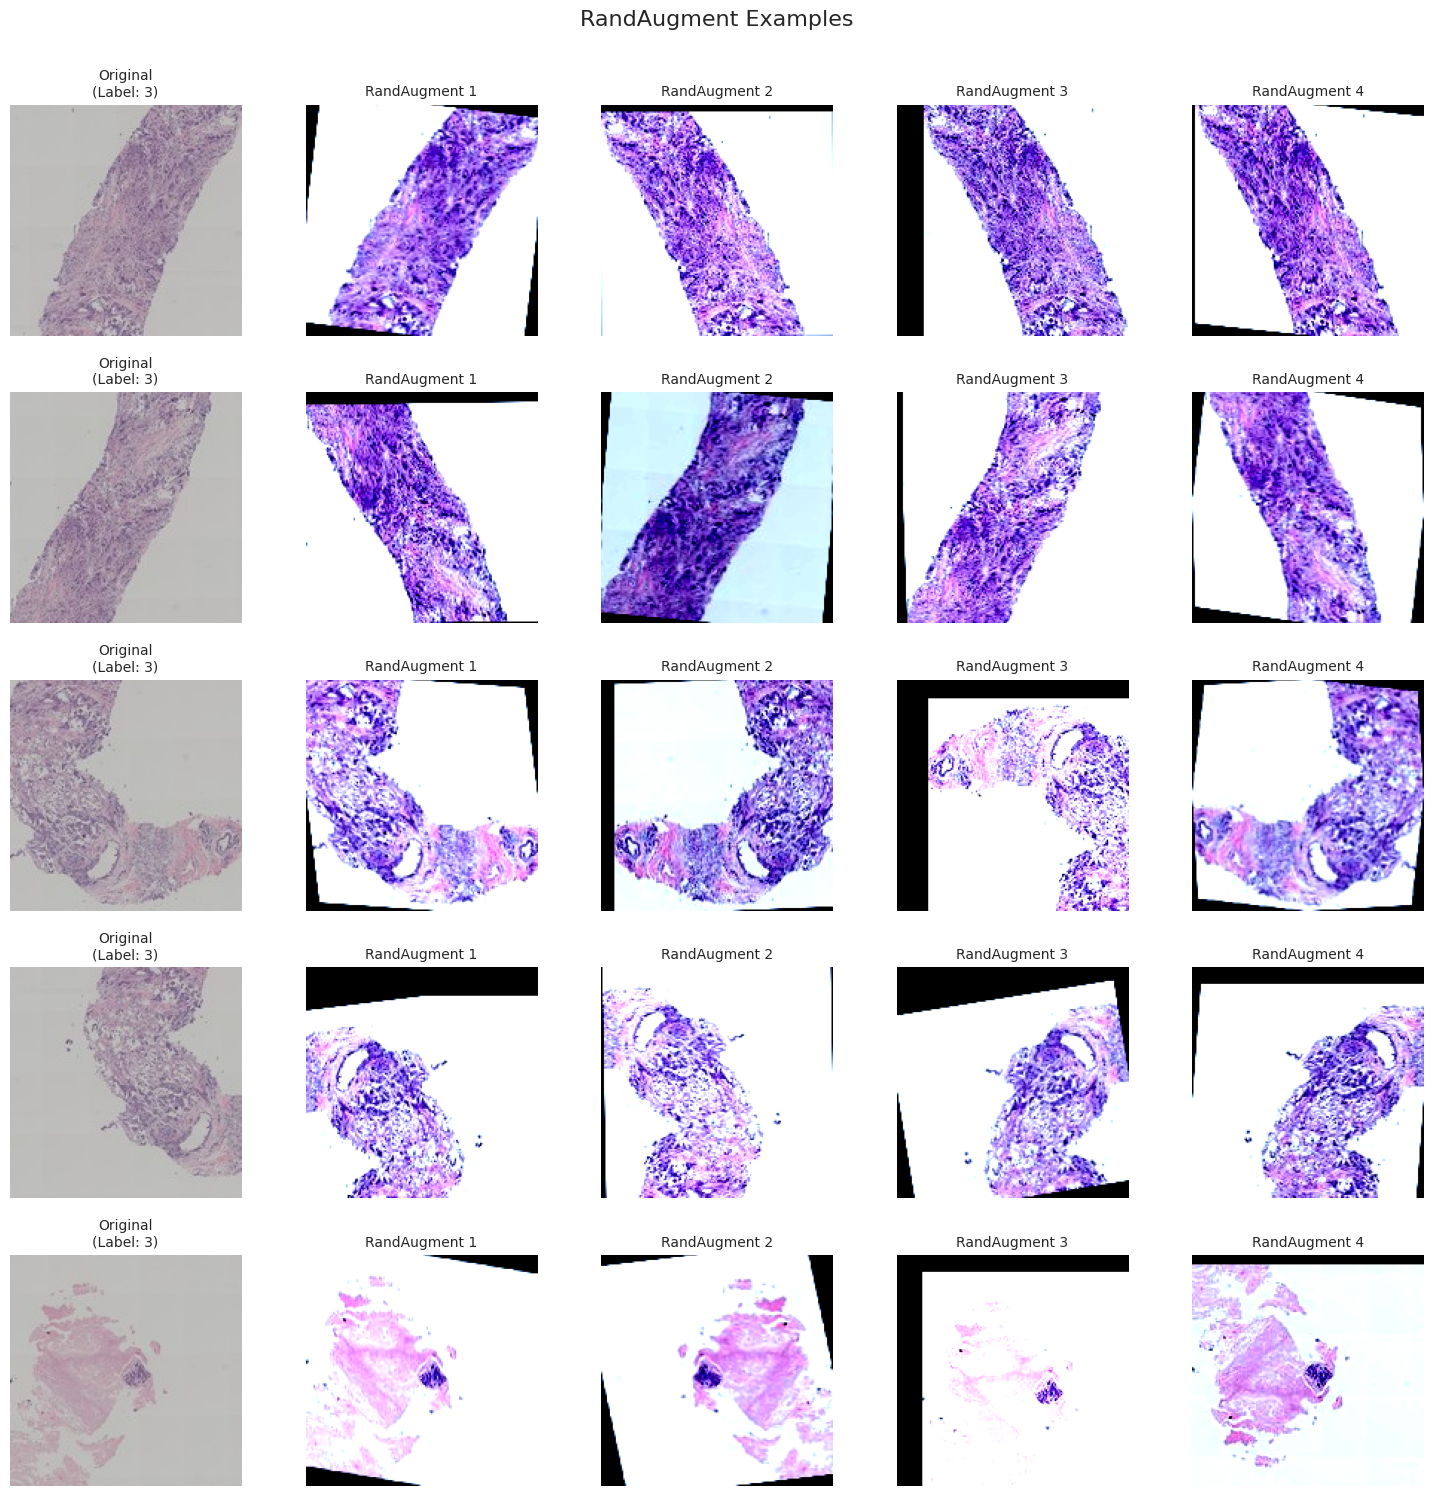

In [ ]:
def visualize_augmentations(dataset,
                            num_samples = 5,
                            augmentations_per_sample = 4,
                            keep_mask = True):
    """
    Visualize original and augmented versions of training samples.

    Args:
        dataset: AugmentedDataset instance
        num_samples: Number of different samples to show
        augmentations_per_sample: Number of augmented versions per sample
        keep_mask: Whether images have their mask as a last channel
    """
    fig, axes = plt.subplots(
        num_samples,
        augmentations_per_sample + 1,
        figsize = (3 * (augmentations_per_sample + 1), 3 * num_samples),
        facecolor = "white"
    )

    # Handle single row case
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i in range(num_samples):
        # --------------------------------------
        # Get original sample (before augmentation)
        # --------------------------------------
        base_sample = dataset.base_dataset[i]

        # Retrocompatibilità:
        # - vecchio caso: (image, label)
        # - nuovo caso:   (img_id, image, label)
        if len(base_sample) == 3:
            _, image, label = base_sample
        elif len(base_sample) == 2:
            image, label = base_sample
        else:
            raise ValueError(f"Unexpected base sample length: {len(base_sample)}")

        # Number of channels (per gestire optional mask)
        C_local = image.shape[0]  # image è tensor (C, H, W)

        # Remove mask (if present)
        if keep_mask and C_local > 3:
            image = image[:(C_local - 1)]

        # Convert grayscale to 3-channel RGB (se mai arrivasse come 1×H×W)
        if image.ndim == 2:
            # grayscale → stack 3 channels
            image = np.stack([image, image, image], axis = -1)

        # Show original
        img = image.permute(1, 2, 0).numpy()
        axes[i, 0].imshow(np.clip(img, 0, 1))
        axes[i, 0].set_title(f"Original\n(Label: {label.item()})", fontsize = 10)
        axes[i, 0].axis('off')

        # --------------------------------------
        # Show augmented versions
        # --------------------------------------
        for j in range(augmentations_per_sample):
            aug_sample = dataset[i]

            # Retrocompatibilità:
            # - vecchio caso: (image_aug, label_aug)
            # - nuovo caso:   (img_id, image_aug, label_aug)
            if len(aug_sample) == 3:
                _, image_aug, _ = aug_sample
            elif len(aug_sample) == 2:
                image_aug, _ = aug_sample
            else:
                raise ValueError(f"Unexpected augmented sample length: {len(aug_sample)}")

            C_aug = image_aug.shape[0]

            # Remove mask (if present)
            if keep_mask and C_aug > 3:
                image_aug = image_aug[:(C_aug - 1)]

            # Convert grayscale to 3-channel RGB (se mai arrivasse come 1×H×W)
            if image_aug.ndim == 2:
                image_aug = np.stack([image_aug, image_aug, image_aug], axis = -1)

            img_aug = image_aug.permute(1, 2, 0).numpy()
            axes[i, j + 1].imshow(np.clip(img_aug, 0, 1))
            axes[i, j + 1].set_title(f"RandAugment {j+1}", fontsize = 10)
            axes[i, j + 1].axis('off')

    plt.suptitle("RandAugment Examples", fontsize = 16, y = 0.998)
    plt.tight_layout()
    plt.show()


visualize_augmentations(train_ds_aug, num_samples = 5, augmentations_per_sample = 4, keep_mask = KEEP_MASK)

### Create data loaders

In [ ]:
from torch.utils.data import DataLoader

def make_loader(ds, batch_size, shuffle, drop_last, sampler=None):
    """
    Create a PyTorch DataLoader with optimized settings.

    Args:
        ds (Dataset): PyTorch Dataset object
        batch_size (int): Number of samples per batch
        shuffle (bool): Whether to shuffle data at each epoch (ignored if sampler is not None)
        drop_last (bool): Whether to drop last incomplete batch
        sampler (Sampler or None): Optional PyTorch sampler (e.g. WeightedRandomSampler)

    Returns:
        DataLoader: Configured DataLoader instance
    """
    # Determine optimal number of worker processes for data loading
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    # Note: se sampler è impostato, shuffle deve essere False (gestito automaticamente)
    return DataLoader(
        ds,
        batch_size = batch_size,
        shuffle = (sampler is None and shuffle),
        sampler = sampler,
        drop_last = drop_last,
        num_workers = num_workers,
        pin_memory = True,  # Faster GPU transfer
        pin_memory_device = "cuda" if torch.cuda.is_available() else "",
        prefetch_factor = 4,  # Load 4 batches ahead
    )


# Create data loaders
train_loader = make_loader(train_ds_aug, batch_size = BATCH_SIZE, shuffle = True,  drop_last = False, sampler=train_sampler)
# train_loader = make_loader(train_ds_aug, batch_size = BATCH_SIZE, shuffle = True,  drop_last = False)
val_loader   = make_loader(val_ds,       batch_size = BATCH_SIZE, shuffle = False, drop_last = False)
test_loader  = make_loader(test_ds,      batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

## 🛠️ **Model Building**

In [ ]:
class BaseCNN(nn.Module):
    def __init__(self,
                 input_shape = (3, 224, 224),
                 num_classes = 4,
                 norm_type = None,
                 dropout_rate = 0.2):
        super().__init__()

        allowed_norms = {"none", "batch", "layer", "instance"}
        norm_key = (norm_type or "none").lower()
        if norm_key not in allowed_norms:
            raise ValueError(
                f"Unsupported norm_type '{norm_type}'. Choose from {allowed_norms}."
            )
        self.norm_type = norm_key

        self.conv0 = nn.Conv2d(input_shape[0], 32, kernel_size=3, padding=1)
        self.bn0 = self._make_norm_layer(32)
        self.relu0 = nn.ReLU()
        self.conv1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn1 = self._make_norm_layer(64)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = self._make_norm_layer(128)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = self._make_norm_layer(256)
        self.relu3 = nn.ReLU()

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Compute flatten size dynamically for fully connected layer
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            x = self._forward_features(dummy_input)
            self.flattened_size = x.view(1, -1).shape[1]

        self.fc = nn.Linear(self.flattened_size, num_classes)

    def _make_norm_layer(self, channels):
        if self.norm_type == "batch":
            return nn.BatchNorm2d(channels)
        elif self.norm_type == "layer":
            return nn.GroupNorm(1, channels)  # LayerNorm for 2D
        elif self.norm_type == "instance":
            return nn.InstanceNorm2d(channels, affine=True)
        else:
            return nn.Identity()

    def _forward_features(self, x):
        x = self.relu0(self.bn0(self.conv0(x)))
        x = self.pool(x)
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.pool(x)
        return x

    def forward(self, x):
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
import torchvision.models as models
from torchvision.models import (
    ResNet18_Weights, ResNet34_Weights, ResNet50_Weights, ResNet101_Weights,
    VGG16_BN_Weights
)
from typing import Optional
import torch
import torch.nn as nn
import torch.nn.functional as F


class TransferLearningNet(nn.Module):
    """
    ResNet/VGG backbone used as frozen feature extractor + MLP classifier head.

    - Expects input tensor x of shape (B, C, H, W) where C == 3 or 4.
      If C == 4, the last channel is the mask (values in [0,1]) but it is IGNORED.
      If C == 3, it is used as-is.
      **ImageNet normalization MANDATORY on RGB in dataset**.

    - The ResNet/VGG backbone (up to features/layer4) extracts generic features.
    - A small MLP head operates on pooled features → logits num_classes.
    """

    def __init__(self,
                 num_classes: int = 4,
                 backbone: str = "vgg16",  # "resnet18/34/50/101", "vgg16"
                 pretrained: bool = True,     # True → IMAGENET1K_V2 (ResNet)/V1 (VGG)
                 freeze_backbone: str = "partial",  # "none", "partial", "all"
                 dropout_rate: float = 0.3):  # Regularization before MLP layers
        """
        Args:
            num_classes: number of output classes.
            backbone: name of torchvision backbone ("resnet18/34/50/101", "vgg16").
            pretrained: if True load best pretrained weights (no deprecation warning).
            freeze_backbone:
                - "none"    → full fine-tuning.
                - "partial" → freeze early blocks (conv1/bn1/layer1/layer2 for ResNet).
                - "all"     → use backbone only as frozen feature extractor.
            dropout_rate: dropout rate inside the MLP classifier.
        """
        super().__init__()

        if freeze_backbone not in {"none", "partial", "all"}:
            raise ValueError(f"Unsupported freeze_backbone '{freeze_backbone}'")
        self.freeze_backbone_mode = freeze_backbone

        self.num_classes = num_classes
        self.feat_channels: Optional[int] = None

        # ------------------------------------------------------------
        # 1) Backbone map: function + pretrained weights
        # ------------------------------------------------------------
        backbone_dict = {
            "resnet18": (models.resnet18, ResNet18_Weights.IMAGENET1K_V1 if pretrained else None),
            "resnet34": (models.resnet34, ResNet34_Weights.IMAGENET1K_V1 if pretrained else None),
            "resnet50": (models.resnet50, ResNet50_Weights.IMAGENET1K_V2 if pretrained else None),
            "resnet101": (models.resnet101, ResNet101_Weights.IMAGENET1K_V2 if pretrained else None),
            "vgg16": (models.vgg16_bn, VGG16_BN_Weights.IMAGENET1K_V1 if pretrained else None),
        }

        if backbone not in backbone_dict:
            raise ValueError(f"Unsupported backbone '{backbone}'")

        model_func, weights = backbone_dict[backbone]
        backbone_model = model_func(weights=weights)

        # ------------------------------------------------------------
        # 1.a) Freeze backbone parameters based on mode
        # ------------------------------------------------------------
        if self.freeze_backbone_mode == "all":
            for p in backbone_model.parameters():
                p.requires_grad = False

        elif self.freeze_backbone_mode == "partial":
            if backbone.startswith("resnet"):
                # Freeze low-level blocks: conv1, bn1, layer1, layer2
                for name, p in backbone_model.named_parameters():
                    if any(name.startswith(pref) for pref in ["conv1", "bn1", "layer1", "layer2", "layer3"]):
                        p.requires_grad = False

            elif backbone == "vgg16":
                # Freeze first half of VGG features (very generic filters)
                num_features = len(backbone_model.features)
                for i, m in enumerate(backbone_model.features):
                    if i < num_features // 2:
                        for p in m.parameters():
                            p.requires_grad = False

        # ------------------------------------------------------------
        # 1.b) Extract convolutional backbone (no classifier head)
        # ------------------------------------------------------------
        if backbone.startswith("resnet"):
            self.backbone_conv = nn.Sequential(
                backbone_model.conv1,
                backbone_model.bn1,
                backbone_model.relu,
                backbone_model.maxpool,
                backbone_model.layer1,
                backbone_model.layer2,
                backbone_model.layer3,
                backbone_model.layer4,
            )
            self.feat_channels = backbone_model.fc.in_features  # e.g., 2048 for ResNet50

        elif backbone == "vgg16":
            self.backbone_conv = backbone_model.features
            self.feat_channels = 512

        # ------------------------------------------------------------
        # 2) Classification head: global pooling + small MLP
        # ------------------------------------------------------------
        head_in = self.feat_channels

        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(head_in, 512),
            nn.ReLU(inplace=True),

            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),

            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes),
        )

        self._init_weights()

    def _init_weights(self):
        # Initialize only newly added Linear layers inside classifier
        for m in self.classifier.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def _split_input(self, x: torch.Tensor):
        """
        Takes input with C = 1,2,3, or 4 channels → rgb (B,3,H,W).
        If a mask channel is present (C==4), it is ignored.
        """
        B, C, H, W = x.shape

        if C == 1:
            rgb = x.repeat(1, 3, 1, 1)
        elif C == 2:
            gray = x[:, :1]
            rgb = gray.repeat(1, 3, 1, 1)
        elif C == 3:
            rgb = x
        elif C == 4:
            rgb = x[:, :3]  # drop mask channel entirely
        else:
            raise ValueError("Input must have 1,2,3, or 4 channels")

        return rgb

    def forward(self, x: torch.Tensor):
        """
        x: tensor (B, C, H, W)
        """
        rgb = self._split_input(x)

        # 1) Backbone conv features (frozen or partially frozen)
        feat = self.backbone_conv(rgb)  # (B, C_f, Hf, Wf)

        # 2) Global average pooling to vector form
        pooled = F.adaptive_avg_pool2d(feat, (1, 1)).view(x.size(0), -1)

        # 3) MLP classifier head
        logits = self.classifier(pooled)
        return logits


In [ ]:
if CNN_TYPE is not None:
    cnn_model = TransferLearningNet(
        num_classes,
        backbone = CNN_TYPE,
        pretrained = PRETRAINED,
        dropout_rate = DROPOUT_RATE
    ).to(device)

else:
    cnn_model = BaseCNN(
        input_shape,
        num_classes,
        dropout_rate = DROPOUT_RATE
    ).to(device)

In [ ]:
!pip install torch-optimizer
import torch_optimizer as optim

# Set up TensorBoard logging and save model architecture
experiment_name = "cnn"
writer = SummaryWriter("./" + logs_dir + "/" + experiment_name)

# Define optimizer with L2 regularization
# optimizer = torch.optim.AdamW(cnn_model.parameters(), lr = LEARNING_RATE, weight_decay = L2_LAMBDA)

# backbone_params   = [p for n,p in cnn_model.backbone_conv.named_parameters() if p.requires_grad]
# classifier_params = list(cnn_model.classifier.parameters())

optimizer = optim.Ranger(
    cnn_model.parameters(),
    lr = LEARNING_RATE,
    weight_decay = L2_LAMBDA,
)


scheduler = None

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled = (device.type == "cuda"))

In [ ]:
class SoftCELoss(nn.Module):
    def __init__(self, eps = 0.05, num_classes = 4):
        super().__init__()
        self.eps = eps
        self.num_classes = num_classes

    def forward(self, logits, target):
        # One-hot encode
        with torch.no_grad():
            soft = torch.zeros_like(logits).scatter_(1, target.unsqueeze(1), 1.0)

            # apply smoothing
            soft = (1 - self.eps) * soft + (self.eps / (self.num_classes - 1))

        logp = torch.log_softmax(logits, dim = 1)
        loss = -(soft * logp).sum(dim = 1).mean()
        return loss

In [ ]:
# Add Focal Loss class definition first
class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance.
    Focuses on hard-to-classify examples.

    Args:
        alpha: class weights (tensor or None)
        gamma: focusing parameter (default: 2.0)
        label_smoothing: label smoothing factor (default: 0.0)
        reduction: 'mean', 'sum', or 'none'
    """
    def __init__(self, alpha=None, gamma=2.0, label_smoothing=0.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.label_smoothing = label_smoothing
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Get cross entropy loss
        ce_loss = nn.functional.cross_entropy(
            inputs,
            targets,
            reduction='none',
            label_smoothing=self.label_smoothing
        )

        # Calculate focal weight
        pt = torch.exp(-ce_loss)
        focal_weight = (1 - pt) ** self.gamma
        focal_loss = focal_weight * ce_loss

        # Apply class weights if provided
        if self.alpha is not None:
            if self.alpha.device != inputs.device:
                self.alpha = self.alpha.to(inputs.device)
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss

        # Apply reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# Updated loss dictionary
loss_dict = {
    "CE": nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING),
    "wCE": nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING, weight=class_weights),
    "sCE": SoftCELoss(eps=LABEL_SMOOTHING),
    "focal": FocalLoss(alpha=None, gamma=2.0, label_smoothing=LABEL_SMOOTHING),
    "wFocal": FocalLoss(alpha=class_weights, gamma=2.0, label_smoothing=LABEL_SMOOTHING),
    "Focal_g1": FocalLoss(alpha=class_weights, gamma=1.0, label_smoothing=LABEL_SMOOTHING),
    "Focal_g3": FocalLoss(alpha=class_weights, gamma=3.0, label_smoothing=LABEL_SMOOTHING),
}

# Loss function selection
try:
    criterion = loss_dict[CRITERION]
except KeyError:
    raise ValueError(f"CRITERION '{CRITERION}' not recognized. Available options: {list(loss_dict.keys())}")

## 🧠 **Model Training**

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device,
                    l1_lambda = 0, l2_lambda = 0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, batch in enumerate(train_loader):
        # Unpack batch: now loader returns (img_id, inputs, targets)
        if len(batch) == 3:
            img_ids, inputs, targets = batch
        else:
            # Fallback per compatibilità (es. vecchi loader: (inputs, targets))
            inputs, targets = batch

        # Move data to device (GPU/CPU)
        inputs  = inputs.to(device)
        targets = targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none = True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type,
                                enabled = (device.type == "cuda")):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            if l1_lambda > 0 or l2_lambda > 0:
                l1_norm = 0.0
                l2_norm = 0.0
                for p in model.parameters():
                    if not p.requires_grad:
                        continue
                    if l1_lambda > 0:
                        l1_norm = l1_norm + p.abs().sum()
                    if l2_lambda > 0:
                        l2_norm = l2_norm + p.pow(2).sum()
                loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm

        # Backward pass with gradient scaling
        scaler.scale(loss).backward()

        # Gradient clipping (AFTER unscale, BEFORE optimizer step)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)

        # Optimizer step with scaled gradients
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim = 1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average = "weighted"
    )

    return epoch_loss, epoch_f1


In [ ]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, f1_score) - Validation loss and weighted F1-score
               computed at IMAGE level (aggregating patches per img_id).

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0

    # Accumulators for image-level aggregation
    image_probs = {}   # img_id -> list of prob vectors (one per patch)
    image_targets = {} # img_id -> single ground-truth label

    # Disable gradient computation for validation
    with torch.no_grad():
        for batch in val_loader:
            # Unpack batch: now loader returns (img_id, inputs, targets)
            if len(batch) == 3:
                img_ids, inputs, targets = batch
            else:
                # Fallback per compatibilità (es. vecchio formato: (inputs, targets))
                inputs, targets = batch
                img_ids = [None] * inputs.size(0)

            # Move data to device
            inputs  = inputs.to(device)
            targets = targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type = device.type,
                                    enabled = (device.type == "cuda")):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate loss (patch-level)
            running_loss += loss.item() * inputs.size(0)

            # Convert logits to probabilities and move to CPU/NumPy
            probs = torch.softmax(logits, dim = 1).cpu().numpy()
            targets_np = targets.cpu().numpy()

            # Accumulate per-image patch predictions
            for img_id, p, t in zip(img_ids, probs, targets_np):
                # Ensure img_id is a hashable scalar (e.g., Python int)
                if isinstance(img_id, torch.Tensor):
                    img_id = img_id.item()

                # Se non abbiamo img_id (fallback vecchio formato), usiamo indice fittizio
                if img_id is None:
                    # In questo caso non ha senso fare agg. per immagine
                    # ma evitiamo crash usando l'indice di loop
                    img_id = id(p)  # chiave unica fittizia

                if img_id not in image_probs:
                    image_probs[img_id] = []
                    image_targets[img_id] = t

                image_probs[img_id].append(p)

    # ----------------------------------------------------
    # Image-level aggregation: media delle prob. per img_id
    # ----------------------------------------------------
    final_preds = []
    final_targets = []

    for img_id in image_probs:
        mean_prob = np.mean(image_probs[img_id], axis = 0)  # average over patches
        pred = np.argmax(mean_prob)
        target = image_targets[img_id]

        final_preds.append(pred)
        final_targets.append(target)

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)  # ancora patch-level, ok
    epoch_f1 = f1_score(
        final_targets,
        final_preds,
        average = "weighted"
    )

    return epoch_loss, epoch_f1


In [ ]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f"{name}/weights", param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f"{name}/gradients", param.grad.data, epoch)

In [ ]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda = 0, l2_lambda = 0, patience = 0, evaluation_metric = "val_f1", mode = "max",
        restore_best_weights = True, writer = None, verbose = 10, experiment_name = "", scheduler=None):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        "train_loss": [], "val_loss": [],
        "train_f1": [], "val_f1": []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float("-inf") if mode == "max" else float("inf")
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Step the scheduler if provided (typically after validation)
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_f1)
            else:
                scheduler.step()

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == "max" else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/" + experiment_name + "_model.pt"))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/" + experiment_name + "_model.pt")

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {trainable:,}")
    print(f"Frozen params:    {total - trainable:,}")

count_parameters(cnn_model)


Total params:     471,364
Trainable params: 471,364
Frozen params:    0


In [153]:
%%time
# Train model and track training history
model, history = fit(
    model = cnn_model,
    train_loader = train_loader,
    val_loader = val_loader,
    epochs = EPOCHS,
    criterion = criterion,
    optimizer = optimizer,
    scaler = scaler,
    device = device,
    writer = writer,
    verbose = 1,
    experiment_name = experiment_name,
    scheduler = scheduler,
    patience = PATIENCE
)

Training 300 epochs...
Epoch   1/300 | Train: Loss=0.1784, F1 Score=0.1739 | Val: Loss=0.1655, F1 Score=0.0256
Epoch   2/300 | Train: Loss=0.1744, F1 Score=0.0512 | Val: Loss=0.1672, F1 Score=0.0256
Epoch   3/300 | Train: Loss=0.1747, F1 Score=0.0555 | Val: Loss=0.1677, F1 Score=0.0256
Epoch   4/300 | Train: Loss=0.1738, F1 Score=0.0497 | Val: Loss=0.1671, F1 Score=0.0256
Epoch   5/300 | Train: Loss=0.1741, F1 Score=0.0517 | Val: Loss=0.1683, F1 Score=0.0256
Epoch   6/300 | Train: Loss=0.1739, F1 Score=0.0534 | Val: Loss=0.1686, F1 Score=0.0256
Epoch   7/300 | Train: Loss=0.1738, F1 Score=0.0661 | Val: Loss=0.1710, F1 Score=0.0256
Epoch   8/300 | Train: Loss=0.1728, F1 Score=0.0928 | Val: Loss=0.1711, F1 Score=0.0379
Epoch   9/300 | Train: Loss=0.1722, F1 Score=0.0954 | Val: Loss=0.1688, F1 Score=0.0879
Epoch  10/300 | Train: Loss=0.1708, F1 Score=0.1207 | Val: Loss=0.1687, F1 Score=0.1107
Epoch  11/300 | Train: Loss=0.1706, F1 Score=0.1201 | Val: Loss=0.1691, F1 Score=0.1194
Epoch  12

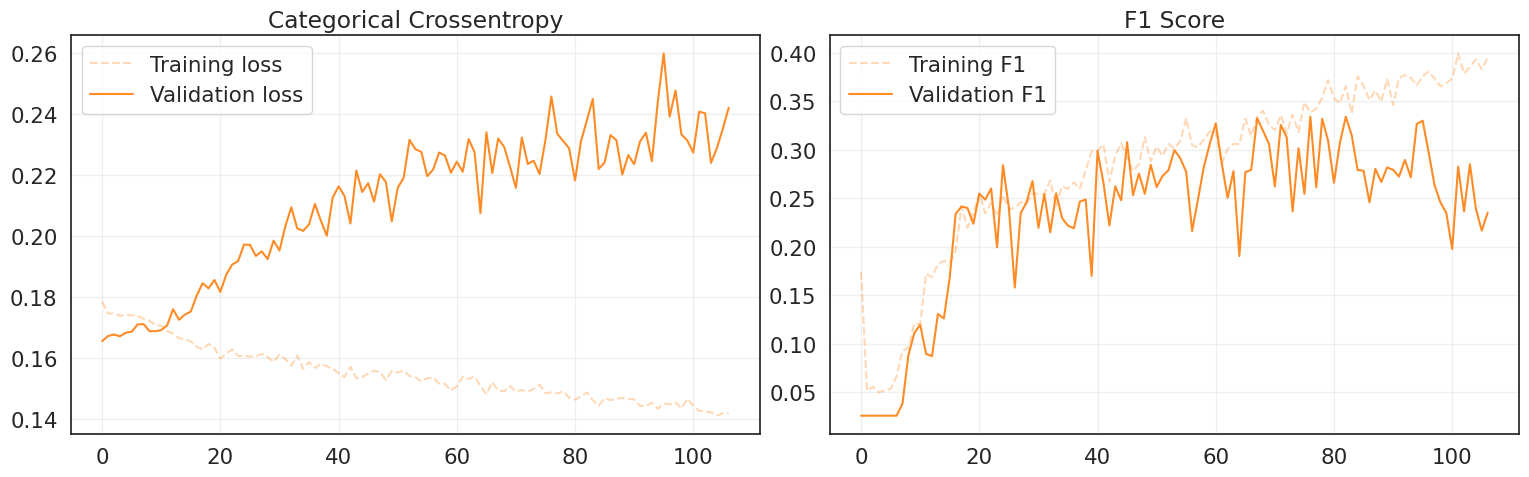

In [154]:
# Create a figure with two side-by-side subplots
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(history['train_loss'], label = "Training loss",   alpha = 0.3, color = "#ff7f0e", linestyle = "--")
ax1.plot(history['val_loss'],   label = "Validation loss", alpha = 0.9, color = "#ff7f0e")
ax1.set_title("Categorical Crossentropy")
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation F1 score on the second axis
ax2.plot(history['train_f1'], label = "Training F1",   alpha = 0.3, color = "#ff7f0e", linestyle = "--")
ax2.plot(history['val_f1'],   label = "Validation F1", alpha = 0.9, color = "#ff7f0e")
ax2.set_title("F1 Score")
ax2.legend()
ax2.grid(alpha = 0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right = 0.85)
plt.show()

In [155]:
def tta_logits(model, x):
    """
    Simple Test-Time Augmentation:
    - original
    - horizontal flip
    - vertical flip
    Averages logits across these 3 variants.
    x: (B, C, H, W)
    """
    logits_list = []

    # original
    logits_list.append(model(x))

    # horizontal flip
    x_h = torch.flip(x, dims=[-1])
    logits_list.append(model(x_h))

    # vertical flip
    x_v = torch.flip(x, dims=[-2])
    logits_list.append(model(x_v))

    return torch.mean(torch.stack(logits_list, dim=0), dim=0)


PATCH-LEVEL METRICS
Accuracy over the validation set:  0.3124
Precision over the validation set: 0.3551
Recall over the validation set:    0.3124
F1 score over the validation set:  0.3231


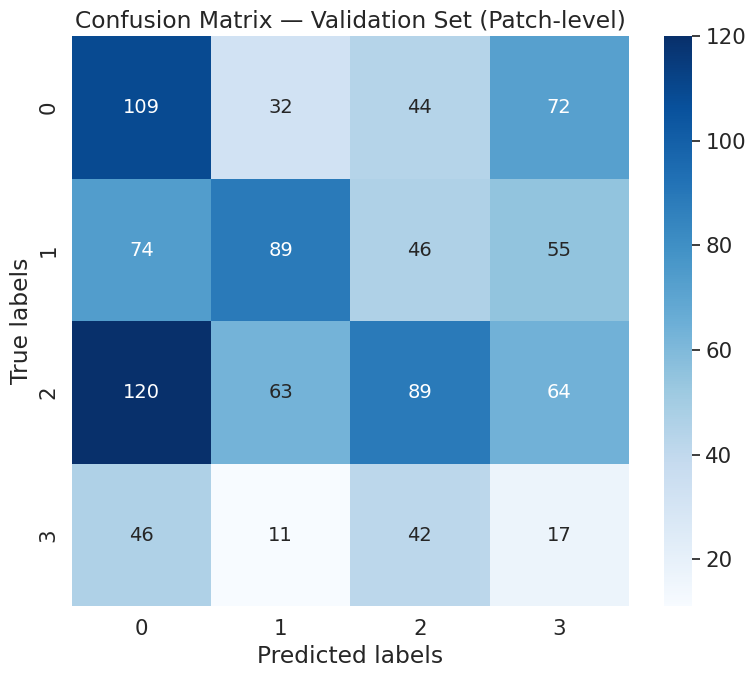

In [156]:
val_preds = []
val_targets = []

model.eval()

with torch.no_grad():  # Disable gradient computation for inference
    for batch in val_loader:
        # Unpack batch: (img_id, inputs, targets) oppure (inputs, targets)
        if len(batch) == 3:
            img_ids, inputs, targets = batch
        else:
            inputs, targets = batch

        inputs  = inputs.to(device)
        targets = targets.to(device)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type,
                                enabled = (device.type == "cuda")):
            logits = model(inputs)
            loss = criterion(logits, targets)  # loss qui non la usi, ma ok per debug

        # Accumulate metrics (PATCH-LEVEL)
        preds = logits.argmax(dim = 1)

        # Store batch results on CPU
        val_preds.append(preds.cpu().numpy())
        val_targets.append(targets.cpu().numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics (PATCH-LEVEL)
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average = "weighted")
val_rec = recall_score(val_targets, val_preds, average = "weighted")
val_f1 = f1_score(val_targets, val_preds, average = "weighted")

print("PATCH-LEVEL METRICS")
print(f"Accuracy over the validation set:  {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set:    {val_rec:.4f}")
print(f"F1 score over the validation set:  {val_f1:.4f}")

# Confusion matrix (PATCH-LEVEL)
cm = confusion_matrix(val_targets, val_preds)

labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

plt.figure(figsize = (8, 7))
sns.heatmap(cm, annot = labels, fmt = "", cmap = "Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix — Validation Set (Patch-level)")
plt.tight_layout()
plt.show()


IMAGE-LEVEL METRICS (patch aggregation)
Accuracy over the validation set:  0.3248
Precision over the validation set: 0.3890
Recall over the validation set:    0.3248
F1 score over the validation set:  0.3371


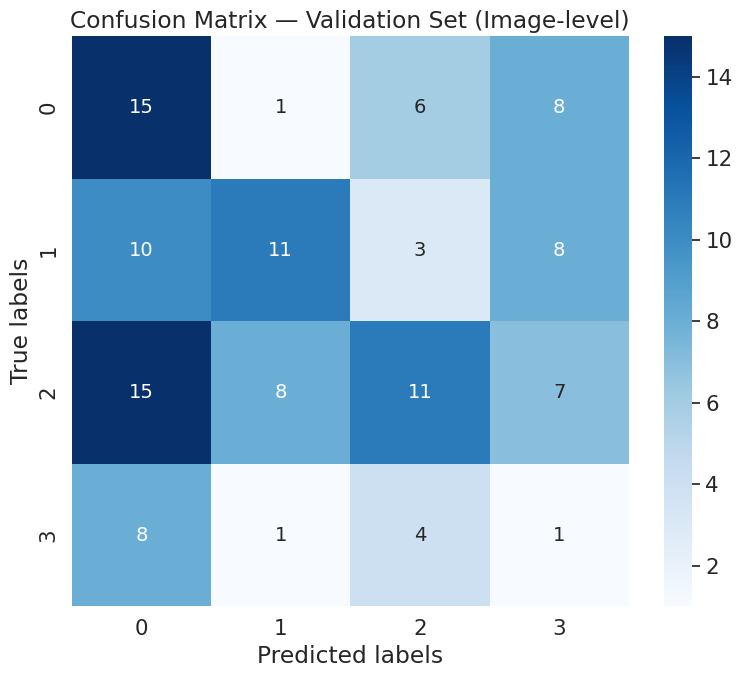

In [157]:
# ============================
# IMAGE-LEVEL VALIDATION METRICS
# ============================

model.eval()

# Accumulator per aggregare le predizioni dei patch di ogni immagine
image_probs = {}    # img_id -> list di vettori di probabilità (uno per patch)
image_targets = {}  # img_id -> singola etichetta ground-truth

with torch.no_grad():  # Disable gradient computation for inference
    for batch in val_loader:
        # Unpack batch: (img_id, inputs, targets)
        if len(batch) == 3:
            img_ids, inputs, targets = batch
        else:
            # Fallback per compatibilità, ma in pratica qui ci aspettiamo 3 elementi
            inputs, targets = batch
            img_ids = [None] * inputs.size(0)

        inputs  = inputs.to(device)
        targets = targets.to(device)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type = device.type,
                        enabled = (device.type == "cuda")):
            logits = tta_logits(model, inputs)

        # Convert logits to probabilities on CPU
        probs = torch.softmax(logits, dim = 1).cpu().numpy()
        targets_np = targets.cpu().numpy()

        # Accumula per img_id
        for img_id, p, t in zip(img_ids, probs, targets_np):
            # img_id può essere tensor → converti a int Python
            if isinstance(img_id, torch.Tensor):
                img_id = img_id.item()

            # Se per qualche motivo fosse None, usa una chiave fittizia unica
            if img_id is None:
                img_id = id(p)

            if img_id not in image_probs:
                image_probs[img_id] = []
                image_targets[img_id] = t

            image_probs[img_id].append(p)

# -----------------------------------------------
# Aggregazione: media delle probabilità per immagine
# -----------------------------------------------
val_img_preds = []
val_img_targets = []

for img_id in image_probs:
    patch_probs = np.stack(image_probs[img_id], axis=0)   # (n_patches, num_classes)
    patch_conf  = patch_probs.max(axis=1)                 # confidence per patch

    k = min(5, len(patch_conf))                           # try K=5
    topk_idx   = np.argsort(-patch_conf)[:k]
    topk_probs = patch_probs[topk_idx]

    mean_prob = topk_probs.mean(axis=0)
    pred   = np.argmax(mean_prob)
    target = image_targets[img_id]

    val_img_preds.append(pred)
    val_img_targets.append(target)


val_img_preds   = np.array(val_img_preds)
val_img_targets = np.array(val_img_targets)

# Metriche IMAGE-LEVEL
val_acc_img  = accuracy_score(val_img_targets, val_img_preds)
val_prec_img = precision_score(val_img_targets, val_img_preds, average = "weighted")
val_rec_img  = recall_score(val_img_targets, val_img_preds, average = "weighted")
val_f1_img   = f1_score(val_img_targets, val_img_preds, average = "weighted")

print("IMAGE-LEVEL METRICS (patch aggregation)")
print(f"Accuracy over the validation set:  {val_acc_img:.4f}")
print(f"Precision over the validation set: {val_prec_img:.4f}")
print(f"Recall over the validation set:    {val_rec_img:.4f}")
print(f"F1 score over the validation set:  {val_f1_img:.4f}")

# Confusion matrix IMAGE-LEVEL
cm_img = confusion_matrix(val_img_targets, val_img_preds)
labels_img = np.array([f"{num}" for num in cm_img.flatten()]).reshape(cm_img.shape)

plt.figure(figsize = (8, 7))
sns.heatmap(cm_img, annot = labels_img, fmt = "", cmap = "Blues")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix — Validation Set (Image-level)")
plt.tight_layout()
plt.show()


## 🕹️ **Inference**

In [158]:
test_probs = []
test_img_ids = []

model.eval()

with torch.no_grad():
    for batch in test_loader:
        if len(batch) == 2:
            img_ids, inputs = batch
        else:
            (inputs,) = batch
            img_ids = [None] * inputs.size(0)

        inputs = inputs.to(device)

        with torch.amp.autocast(device_type = device.type,
                        enabled = (device.type == "cuda")):
            logits = tta_logits(model, inputs)

        probs = F.softmax(logits, dim = 1).cpu().numpy()

        test_probs.append(probs)
        test_img_ids.extend(list(img_ids))

test_probs = np.concatenate(test_probs, axis = 0)


In [159]:
# Count how many patches per sample_index
patches_per_sample = X_c_test.groupby('sample_index').size().to_dict()

# Initialize vector of final label predictions
test_preds = []
pointer = 0

# Get label prediction for each sample
for sample_index in X_c_test['sample_index'].unique():
    n_patches = patches_per_sample[sample_index]

    sample_patch_probs = test_probs[pointer:pointer + n_patches]  # (n_patches, num_classes)
    pointer += n_patches

    patch_conf = sample_patch_probs.max(axis=1)
    k = min(5, len(patch_conf))
    topk_idx   = np.argsort(-patch_conf)[:k]
    topk_probs = sample_patch_probs[topk_idx]

    mean_probs = topk_probs.mean(axis=0)
    final_label = np.argmax(mean_probs)
    test_preds.append((sample_index, final_label))

In [160]:
sample_indexes, numeric_preds = zip(*test_preds)

# Convert numeric predictions to strings
labels = [int_to_label [p] for p in numeric_preds]

# Build DataFrame
results = pd.DataFrame({
    "sample_index": sample_indexes,
    "label": labels
})

In [161]:
from google.colab import files

# Save CSV locally in the Colab environment
results.to_csv("test_labels.csv", index=False)

# Download to your device
files.download("test_labels.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>